# Imports 

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import time 
import matplotlib

print(f'Numpy: {np.__version__}')
print(f'Pandas: {pd.__version__}')
print(f'Sklearn: {sklearn.__version__}')
print(f'Matplotlib: {matplotlib.__version__}')

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import matplotlib.pyplot as plt

from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score

# ML models 
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
#from numpy import mean

# Validation metrics
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate

# Variables


In [ ]:
train_path = '/kaggle/input/isic-2024-challenge/train-metadata.csv'
test_path = '/kaggle/input/isic-2024-challenge/test-metadata.csv'

In [ ]:
# common columns
#train_cols_set, test_cols_set = set(train_data.columns), set(test_data.columns)
#cols = list(test_cols_set.intersection(train_cols_set))

common_cols = ['sex', 'tbp_lv_deltaLB', 'tbp_lv_location_simple', 'tbp_lv_areaMM2', 'tbp_lv_deltaL', 'tbp_lv_norm_border', 'tbp_lv_A',
 'tbp_lv_B', 'tbp_lv_symm_2axis', 'tbp_lv_L', 'tbp_lv_location', 'tbp_lv_deltaLBnorm', 'tbp_lv_radial_color_std_max',
 'tbp_lv_Lext',  'tbp_lv_Bext', 'tbp_lv_H', 'tbp_lv_perimeterMM', 'tbp_lv_stdL', 'tbp_lv_minorAxisMM', 'tbp_lv_stdLExt',
 'tbp_lv_y', 'tbp_lv_color_std_mean', 'clin_size_long_diam_mm', 'age_approx', 'tbp_lv_eccentricity', 'tbp_lv_deltaA',
 'tbp_tile_type', 'tbp_lv_Hext', 'tbp_lv_C', 'tbp_lv_norm_color', 'tbp_lv_deltaB', 'anatom_site_general', 'tbp_lv_x',
 'tbp_lv_Aext',  'tbp_lv_Cext', 'tbp_lv_symm_2axis_angle', 'tbp_lv_nevi_confidence', 'tbp_lv_z', 'tbp_lv_area_perim_ratio']

In [ ]:
# patient_id: Unique patient identifier. (object)
# image_type: Structured field of the ISIC Archive for image type. (o)
# copyright_license: Copyright license. (object)
to_drop = ['isic_id','patient_id','image_type', 'copyright_license', 'attribution']

In [ ]:
# categorical columns 
cat_cols_list = ['sex','tbp_lv_location_simple', 'tbp_lv_location', 'tbp_tile_type', 'anatom_site_general']

# mapping 
sex = {'male':0, 'female':1}
tbp_lv_location_simple =  {'Head & Neck': 0, 'Left Arm': 1, 'Left Leg': 2, 'Right Arm': 3, 'Right Leg': 4, 'Torso Back': 5, 
                           'Torso Front': 6}

tbp_lv_location = {'Head & Neck': 0, 'Left Arm': 1,'Left Arm - Lower': 2, 'Left Arm - Upper': 3,'Left Leg': 4, 
                   'Left Leg - Lower': 5, 'Left Leg - Upper': 6, 'Right Arm': 7, 'Right Arm - Lower': 8, 'Right Arm - Upper': 9, 'Right Leg': 10, 'Right Leg - Lower': 11,
  'Right Leg - Upper': 12, 'Torso Back': 13, 'Torso Back Bottom Third': 14, 'Torso Back Middle Third': 15, 'Torso Back Top Third': 16,
  'Torso Front': 17, 'Torso Front Bottom Half': 18, 'Torso Front Top Half': 19}

tbp_tile_type = {'3D: XP': 0, '3D: white': 1}

anatom_site_general = {'anterior torso': 0, 'head/neck': 1, 'lower extremity': 2, 'posterior torso': 3, 'upper extremity': 4}

# genral dictionary
cat_cols = {'sex': sex, 
           'tbp_lv_location_simple':tbp_lv_location_simple, 
           'tbp_lv_location': tbp_lv_location, 
           'tbp_tile_type':tbp_tile_type,
           'anatom_site_general': anatom_site_general}

# Functions

In [ ]:
class Data: 
    
    def __init__(self, path, drop_cols, common_columns, categorical_cols, target_col):
        self.path = path
        self.drop_cols = drop_cols
        self.common_columns = common_columns 
        self.categorical_cols = categorical_cols
        self.target_col = target_col
    
    def data_prep(self):
        #read data
        self.df = pd.read_csv(self.path,  low_memory=False)
        
        # shuflle data
        self.df = self.df.sample(frac=1).reset_index(drop=True)
        print(f'Data Shape: {self.df.shape}')
        
        #drop columns
        self.df.drop(columns=self.drop_cols, axis=1, inplace=True)
        print(f'Cols to drop:{len(self.drop_cols)}.Data Shape: {self.df.shape}')      
        
        #common columns
        if self.target_col:
            self.common_columns.append('target')
        
        self.df = self.df[self.common_columns]
        print(f'Common Cols:{len(self.common_columns)}.Data Shape: {self.df.shape}')
        
        # drop missing values
        missing_vals = self.df.isnull().sum().sum()
        if missing_vals > 0:
            self.df = self.df.dropna()
            self.df = self.df.reset_index (drop = True)
        print(f'Missing Vals:{missing_vals}.Data Shape: {self.df.shape}')
            
        # encode categorical cols
        #self.df = pd.get_dummies( self.df, columns=categorical_cols)
        
        # remove dublicate 
        #self.df.duplicated().sum() == 0 the dataset contains no dublicated values 
        
        #columns mapping
        for key in self.categorical_cols.keys():
            self.df[key] = self.df[key].map(self.categorical_cols[key])
        
        # standarization
        scaler = StandardScaler()
        
        if self.target_col:
            df_feat = self.df.drop(columns=['target'])
            df_target = self.df['target']
            cols = df_feat.columns
            self.df = scaler.fit_transform(df_feat)
            self.df = pd.DataFrame(self.df, columns=cols)
            self.df['target'] = df_target
        else: 
            cols = self.df.columns
            self.df = scaler.fit_transform(self.df)
            self.df = pd.DataFrame(self.df, columns=cols)
        
        if self.target_col:
            self.common_columns.remove('target')
        
        print(f'Final Data Shape: {self.df.shape}')
        
    def get_data(self):
        return self.df

In [ ]:
class Split_data():
    
    def __init__(self, df, features_selected):
        self.df = df
        self.features_selected = features_selected
        
    def split_data(self, test_size = 0.2):
        featuers, target = train_df.columns[:-1], train_df.columns[-1] # features / target
        self.X, self.y = self.df[featuers],  self.df.target #Split Data
        # train test split
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=test_size, stratify=self.y)
        print(f'X train:{self.X_train.shape} y train:{self.y_train.shape}\nX test:{self.X_test.shape} y test:{self.y_test.shape}')
        print(f'y train {self.y_train.value_counts()}')
        print(f'y test {self.y_test.value_counts()}')
        
    def get_X_y(self):
        return self.X, self.y
    
    def feature_selector(self):
        self.X_train = self.X_train[self.features_selected]#.values
        self.X_test = self.X_test[self.features_selected]#.values
        print(f'Train Data:{self.X_train.shape}.\nTest Data:{self.X_test.shape}')
    
    def get_data(self):
        return self.X_train, self.y_train, self.X_test, self.y_test


In [ ]:
def model_eval_metrics(y_test, y_pred):
    print("Acc:", accuracy_score(y_test, y_pred))
    print("Balanced Acc:",balanced_accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print(f'Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}')

In [ ]:
class Data_split_procedure: 
    
    def __init__(self, X_df, y_df):
        self.X_df = X_df
        self.y_df = y_df
    
    def create_subdata(self):
        # Create multiple sub datasets from the main data 
        Xy_train = self.X_df.copy() # copy training data 
        Xy_train['target'] = self.y_df # add the target column
        
        # data with only normal flows (0) 
        Xy_majior = Xy_train[Xy_train['target'] == 0] 
        Xy_majior = Xy_majior.sample(frac=1).reset_index(drop=True) # suffle dataset for random spliting  
        
        # malicius data flows dataset
        Xy_minor = Xy_train[Xy_train['target'] == 1]
        #split the majior dataset in to 5 subdatasets
        split_majior = np.array_split(Xy_majior, 5)
        
        # list of datasets 
        self.dfs = []
        for i in range(len(split_majior)): 
            df_majior = split_majior[i]
            # Concatenate the subdataset (malicius+normal) reset index
            df_majior_minor = pd.concat([df_majior, Xy_minor], ignore_index=True)  
            df_majior_minor = df_majior_minor.sample(frac=1).reset_index(drop=True) # suffle 
            self.dfs.append(df_majior_minor)
            
        return self.dfs
        

In [ ]:
class ML_model():
    
    def __init__(self, list_dfs, model, cv_method):
        self.list_dfs = list_dfs
        self.model = model
        self.cv_method = cv_method  

    # Define the custom scoring functions
    def macro_precision(self, y_true, y_pred):
        return precision_score(y_true, y_pred, average='macro')

    def macro_recall(self, y_true, y_pred):
        return recall_score(y_true, y_pred, average='macro')

    def macro_f1(self, y_true, y_pred):
        return f1_score(y_true, y_pred, average='macro')

    def roc_auc(self, y_true, y_pred):
        return roc_auc_score(y_true, y_pred, average='macro', multi_class='ovo')
    
    def model_fit(self):
        self.result = {}
        ii, ij = 0, 0

        for i in range(len(self.list_dfs)): # for each dataset train model with CV 
            keys = ['prec', 'rec', 'f1', 'roc_']
            eval_dict = {key: None for key in keys}

            print(f'Data:{ij}')
            X_dfs, y_dfs = self.list_dfs[i].iloc[:, :-1], self.list_dfs[i].iloc[:, -1]
            
            ij +=1

            pred_lst, rec_lst, f1_lst, roc_lst = [], [], [], []
            for train_indx, test_indx in self.cv_method.split(X_dfs, y_dfs):

                print(f'Fold:{ii}')
                X_train, X_test = X_dfs.iloc[train_indx], X_dfs.iloc[test_indx]
                y_train, y_test = y_dfs.iloc[train_indx], y_dfs.iloc[test_indx]
                
                eval_set = [(X_train, y_train), (X_test, y_test)]
                
                self.model.fit(X_train, y_train)
                
                y_pred = self.model.predict(X_test)
                #print(y_test.shape, y_pred.shape)
                
                prec = self.macro_precision(y_true=y_test, y_pred=y_pred)
                rec = self.macro_recall(y_true = y_test, y_pred = y_pred)
                f1 = self.macro_f1(y_true = y_test, y_pred = y_pred)
                roc_ = self.roc_auc(y_true = y_test, y_pred = y_pred)

                pred_lst.append(prec)
                rec_lst.append(rec)
                f1_lst.append(f1)
                roc_lst.append(roc_)
                #print(f'clf Report:\n{classification_report(y_test, y_pred)}')
                ii +=1 

            eval_dict['prec'] = pred_lst
            eval_dict['rec'] = rec_lst
            eval_dict['f1'] = f1_lst
            eval_dict['roc_'] = roc_lst

            self.result[i] = eval_dict
        
        return self.result, self.model

In [ ]:
def visual_result(results_dict):

    fig, ax = plt.subplots(3, 2, figsize=(14, 14))
    ax = ax.flatten()
    positions = [5, 10]
    
    # Plot 1 fold
    ax[0].plot(results_dict[0]['prec'], marker='o')
    ax[0].plot(results_dict[0]['prec'], marker='o', label='Precision')
    ax[0].plot(results_dict[0]['rec'], marker='s', label='Recall')
    ax[0].plot(results_dict[0]['f1'], marker='^', label='F1 Score')
    ax[0].plot(results_dict[0]['roc_'], marker='d', label='ROC AUC')
    
    for pos in positions:
        ax[0].axvline(x=pos, color='k', linestyle='--', linewidth=1)
        
    ax[0].set_title('Performance Metrics over Repeated 1-Fold Cross Validation')
    ax[0].set_xlabel('Fold')
    ax[0].set_ylabel('Score')

    # Plot 2 fold
    ax[1].plot(results_dict[1]['prec'], marker='o')
    ax[1].plot(results_dict[1]['prec'], marker='o', label='Precision')
    ax[1].plot(results_dict[1]['rec'], marker='s', label='Recall')
    ax[1].plot(results_dict[1]['f1'], marker='^', label='F1 Score')
    ax[1].plot(results_dict[1]['roc_'], marker='d', label='ROC AUC')
    
    for pos in positions:
        ax[1].axvline(x=pos, color='k', linestyle='--', linewidth=1)
        
    ax[1].set_title('Performance Metrics over Repeated 3-Fold Cross Validation')
    ax[1].set_xlabel('Fold')
    ax[1].set_ylabel('Score')

    # Plot 3 fold
    ax[2].plot(results_dict[2]['prec'], marker='o')
    ax[2].plot(results_dict[2]['prec'], marker='o', label='Precision')
    ax[2].plot(results_dict[2]['rec'], marker='s', label='Recall')
    ax[2].plot(results_dict[2]['f1'], marker='^', label='F1 Score')
    ax[2].plot(results_dict[2]['roc_'], marker='d', label='ROC AUC')
    
    for pos in positions:
        ax[2].axvline(x=pos, color='k', linestyle='--', linewidth=1)
        
    ax[2].set_title('Performance Metrics over Repeated 4-Fold Cross Validation')
    ax[2].set_xlabel('Fold')
    ax[2].set_ylabel('Score')
    
    
    # Plot 4 fold
    ax[3].plot(results_dict[3]['prec'], marker='o')
    ax[3].plot(results_dict[3]['prec'], marker='o', label='Precision')
    ax[3].plot(results_dict[3]['rec'], marker='s', label='Recall')
    ax[3].plot(results_dict[3]['f1'], marker='^', label='F1 Score')
    ax[3].plot(results_dict[3]['roc_'], marker='d', label='ROC AUC')
    
    for pos in positions:
        ax[3].axvline(x=pos, color='k', linestyle='--', linewidth=1)
    ax[3].set_title('Performance Metrics over Repeated 5-Fold Cross Validation')
    
    ax[3].set_xlabel('Fold')
    ax[3].set_ylabel('Score')
    
    # Plot 5 fold
    ax[4].plot(results_dict[4]['prec'], marker='o')
    ax[4].plot(results_dict[4]['prec'], marker='o', label='Precision')
    ax[4].plot(results_dict[4]['rec'], marker='s', label='Recall')
    ax[4].plot(results_dict[4]['f1'], marker='^', label='F1 Score')
    ax[4].plot(results_dict[4]['roc_'], marker='d', label='ROC AUC')
    
    for pos in positions:
        ax[4].axvline(x=pos, color='k', linestyle='--', linewidth=1)
        
    ax[4].set_title('Performance Metrics over Repeated 2-Fold Cross Validation')
    ax[4].set_xlabel('Fold')
    ax[4].set_ylabel('Score')
    
    fig.delaxes(ax[5])
    # Adjust layout
    plt.legend()
    plt.tight_layout()
    plt.show()

# Main

**PipeLine:**
* Data Pre-processing
    * Identify the most nessecary columns 
    * Identify the null values / drop
    * Identify the common columns (train df :55/ test df:44)
    * Mapping the categorical columns
    * Standardize the data 
* Feature Extraction Techniques
    * Filter Methods/ Intersection
        * ANOVA (https://ietresearch.onlinelibrary.wiley.com/doi/pdfdirect/10.1049/ipr2.13002)
        * Chi2 (https://ietresearch.onlinelibrary.wiley.com/doi/pdfdirect/10.1049/ipr2.13002)
        * Fisher (https://ietresearch.onlinelibrary.wiley.com/doi/pdfdirect/10.1049/ipr2.13002)
        * mRMR Algorithm (https://home.penglab.com/papersall/docpdf/2004_JBCB_feasel-04-06-15.pdf)
    * Embedded Methods
        * Random Forest 
        * Elastic Net
* Feature Correlation with the target
* weights for each class
* Models for prediction / evaluation -> MLPclassifier, ANN, *XGBoost*, RandomForest

In [ ]:
# train data 
data_train = Data(path = train_path,
           drop_cols = to_drop, 
           common_columns = common_cols, 
           categorical_cols= cat_cols, 
           target_col = True)
data_train.data_prep()

train_df = data_train.get_data()

In [ ]:
#test data
data_test = Data(path = test_path,
           drop_cols = to_drop, 
           common_columns = common_cols, 
           categorical_cols= cat_cols, 
                target_col = False)
data_test.data_prep()
test_df = data_test.get_data()

In [ ]:
print(f'Train Shape:{train_df.shape}\nTest Shape:{test_df.shape}')

The Feature Extraction Section uses Chi-Square, ANOVA F-score, Fisher score and mRMR method to identify the most relevat features. Then Intersection is used to find the common features.  

Chi 2: 27 \
ANOVA:32 \
Fisher:32 \
mRMR:22 \
Common features:15

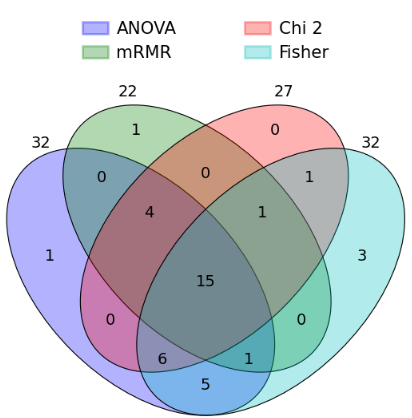

In [ ]:
intersection_cols = ['clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_areaMM2',
  'tbp_lv_color_std_mean', 'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_location', 'tbp_lv_location_simple',
  'tbp_lv_minorAxisMM', 'tbp_lv_norm_color', 'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max',
  'tbp_lv_stdL']

In [ ]:
train_df['target'].value_counts()

In [ ]:
split = Split_data(df = train_df, features_selected = list(intersection_cols))
split.split_data()
split.feature_selector()
X, y = split.get_X_y()
X_train, y_train, X_test, y_test = split.get_data()

In [ ]:
split_data = Data_split_procedure(X_train, y_train)
dfs_lst = split_data.create_subdata()

## XGBoost Model 

## Hyperparameter Tunning

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# compute weights for the training of the model
xgb_params = {}
classes = np.unique(y_train)

class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, class_weights))
n_pos, n_neg = sum(y_train == 1), sum(y_train == 0)
scale_pos_weight = n_neg / n_pos

print(f'scale_pos_weight:{scale_pos_weight}')

GridSearch for hyperparameter Tunning

In [ ]:
# # sample of data for hyperparameter tunning 
# sample_df = dfs_lst[0]
# X_sample, y_sample = sample_df.iloc[:, :-1], sample_df.iloc[:, -1]

# # hyperparams for search 
# hyper_params  = {'alpha' : [0.1],
# 'lambda': [1, 3, 10],
# 'gamma': [0.1, 0.5, 1],
# 'n_estimators': [250, 150],
# 'learning_rate':[0.1],
# 'max_depth':[10, 15, 20],
# 'scale_pos_weight': [1000.7409836065574],
# 'objective': ['binary:logistic']}

# # Model
# xbst_grid = XGBClassifier()

# # GridSearchCV
# grid = GridSearchCV(estimator=xbst_grid, param_grid=hyper_params,
#                     scoring='f1', n_jobs=-1, verbose=3 )
# grid.fit(X_sample, y_sample)

In [ ]:
best_params_ = {'alpha': 0.1, 'gamma': 0.5, 'lambda': 10, 
                'learning_rate': 0.1, 'max_depth': 10, 
                'n_estimators': 150, 'objective': 'binary:logistic', 
                'scale_pos_weight': 1000.7409836065574}
print(best_params_)

In [ ]:
RS_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
xbst = XGBClassifier(**best_params_)

In [ ]:
xgb_model_split = ML_model(list_dfs = dfs_lst, model = xbst, cv_method = RS_cv)
results_xgb, xgb_model = xgb_model_split.model_fit()

In [ ]:
visual_result(results_xgb)

## MLP 

In [ ]:
# from sklearn.neural_network import MLPClassifier
# mlp = MLPClassifier()
# mlp_model_split = ML_model(list_dfs = dfs_lst, model = mlp, cv_method = RS_cv)
# results_mlp, mlp_model = mlp_model_split.model_fit()
# visual_result(results_mlp)

# Test Results

In [ ]:
test_path = '/kaggle/input/isic-2024-challenge/test-metadata.csv'
test_df = pd.read_csv(test_path)
unseen_target = test_df.isic_id

In [ ]:
##Pre-processing of the test data 
# Columns name
cols = xgb_model.get_booster().feature_names

test_df = test_df[cols]
test_cols  = test_df.columns

# Mapping 
for key in cat_cols.keys():
    if key in test_cols: 
        test_df[key] = test_df[key].map(cat_cols[key])

# standar Scaler
scaler = StandardScaler()
test_df = scaler.fit_transform(test_df)

# Data Frame 
test_data = pd.DataFrame(test_df, columns=test_cols)

In [ ]:
#Model prediction 
model_pred = xgb_model.predict_proba(test_data)
model_pred

In [ ]:
unseen_dict = {"isic_id":[] , "target":[]}
isic_id_lst, model_pred_lst = [], []

for i, pred  in enumerate(model_pred): 
    unseen_dict['isic_id'].append(unseen_target[i])
    unseen_dict['target'].append(pred[1])

unseen_dict

In [ ]:
pd.DataFrame(unseen_dict).to_csv("submission.csv", index=False)